## Social analytics for social goods

### Project: Routing optimization based on the prediction of necessary vaccines by health region of Catalonia.

The first part about our project is predict the number of vaccines that each health region will need in the following 5 days.

## 0. Import libraries

In [218]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
pd.set_option('display.max_columns', None)
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
import matplotlib.pyplot as plt
import datetime
import json
import re
from pandas_profiling import ProfileReport
import time
from geopy.geocoders import Nominatim
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm

## 1. Data Gathering

In [219]:
#Download data 05/03. 
vacun = pd.read_csv('Vacunaci__per_al_COVID-19_5març.csv', error_bad_lines=False, sep = ';')

## 2. Data Processing

In [220]:
vacun.head()

,SEXE_CODI,SEXE,REGIO_CODI,REGIO,SECTOR_CODI,SECTOR,AGA_CODI,AGA,ABS_CODI,ABS,EDAT,DOSI,DATA,FABRICANT,NO_VACUNAT,RECOMPTE
0,1.0,Dona,7801.0,METROPOLITANA SUD,7866.0,BAIX LLOBREGAT CENTRE-LITORAL I L'H,24.0,Baix Llobregat Centre i Fontsanta -L'H N,216.0,SANT JUST DESVERN,15 a 64,1,05/02/2021,Moderna / Lonza,NaN,3
1,1.0,Dona,6400.0,GIRONA,6462.0,GIRONA SUD,57.0,Gironès Nord i Pla de l'Estany,15.0,BANYOLES,15 a 64,1,05/01/2021,BioNTech / Pfizer,NaN,31
2,1.0,Dona,7803.0,BARCELONA CIUTAT,7850.0,BARCELONA SARRIÀ-SANT GERVASI,47.0,Barcelona Nord,46.0,BARCELONA 5-E,15 a 64,1,13/01/2021,BioNTech / Pfizer,NaN,60
3,1.0,Dona,6200.0,CAMP DE TARRAGONA,6257.0,ALT CAMP-CONCA DE BARBERÀ,6.0,Alt Camp i Conca de Barberà,162.0,MONTBLANC,15 a 64,1,23/01/2021,BioNTech / Pfizer,NaN,77
4,1.0,Dona,6700.0,CATALUNYA CENTRAL,6735.0,ANOIA,19.0,Anoia,372.0,IGUALADA-2,15 a 64,1,11/01/2021,BioNTech / Pfizer,NaN,21


In [221]:
vacun.columns = vacun.columns.str.strip()
vacun.columns = vacun.columns.str.replace(' ', '_')
vacun.columns = vacun.columns.astype(str).str.lower()

In [222]:
vacun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107783 entries, 0 to 107782
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sexe_codi    107662 non-null  float64
 1   sexe         107783 non-null  object 
 2   regio_codi   107629 non-null  float64
 3   regio        107783 non-null  object 
 4   sector_codi  107629 non-null  float64
 5   sector       107783 non-null  object 
 6   aga_codi     107629 non-null  float64
 7   aga          107783 non-null  object 
 8   abs_codi     107629 non-null  float64
 9   abs          107783 non-null  object 
 10  edat         107783 non-null  object 
 11  dosi         107783 non-null  int64  
 12  data         107783 non-null  object 
 13  fabricant    100886 non-null  object 
 14  no_vacunat   6897 non-null    object 
 15  recompte     107783 non-null  int64  
dtypes: float64(5), int64(2), object(9)
memory usage: 13.2+ MB


Vamos a utilizar solamente el sexo,  la zona donde se ha vacunado, la edad, el día, el tipo de vacuna, la dosi y cuanta gente no se ha vacunado.

In [223]:
vacun = vacun[['sexe', 'regio', 'edat',  'dosi', 'data', 'fabricant', 'no_vacunat' ]]

In [224]:
vacun['data'] = vacun.loc[:,'data'] = pd.to_datetime(vacun.data.astype(str), format="%d/%m/%Y")

In [225]:
print("La primera muestra la obtenemos el día " + str(vacun.data.min()) + " y la última muestra la obtenemos el día " + str(vacun.data.max()))

La primera muestra la obtenemos el día 2020-12-27 00:00:00 y la última muestra la obtenemos el día 2021-03-04 00:00:00


In [226]:
vacun.isnull().sum()

sexe               0
regio              0
edat               0
dosi               0
data               0
fabricant       6897
no_vacunat    100886
dtype: int64

In [227]:
print('Sabemos que ' + str(vacun.fabricant.isnull().sum()) + ' personas de las ' + str(len(vacun)) + ' personas que estaban citadas no se han vacunado.')
print("Por lo tanto se ha vacunado el {:.2f}".format(100 * (1 - (vacun.fabricant.isnull().sum()) / (len(vacun)))) + " %.")

Sabemos que 6897 personas de las 107783 personas que estaban citadas no se han vacunado.
Por lo tanto se ha vacunado el 93.60 %.


In [228]:
#Eliminamos aquellas personas que no se hayan vacunado y que el tipo de datos de la persona no se sepa.
vacun_ = vacun[vacun['fabricant'].isnull() == False]
vacun_ = vacun_[vacun_['regio'] != 'No classificat']
#Creamos una lista con las diferentes regiones
listaRegions = vacun_['regio'].unique()

In [229]:
#hacemos el groupby por día, por región sumamos las dosis.
vacun_groupby = vacun_.groupby(['data', 'regio'], as_index=False)['fabricant'].count().rename({"fabricant": "contador"}, axis = 1)
vacun_groupby.head(10)

,data,regio,contador
0,2020-12-27,ALT PIRINEU I ARAN,7
1,2020-12-27,BARCELONA CIUTAT,29
2,2020-12-27,CAMP DE TARRAGONA,27
3,2020-12-27,CATALUNYA CENTRAL,19
4,2020-12-27,GIRONA,15
5,2020-12-27,LLEIDA,16
6,2020-12-27,METROPOLITANA NORD,30
7,2020-12-27,METROPOLITANA SUD,19
8,2020-12-27,TERRES DE L'EBRE,8
9,2020-12-28,METROPOLITANA NORD,1


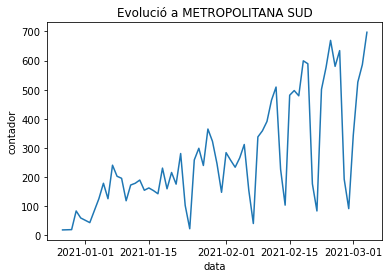

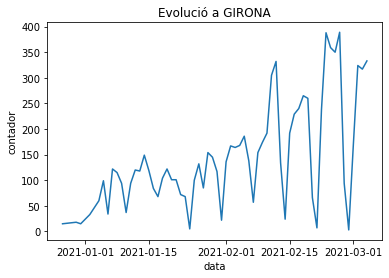

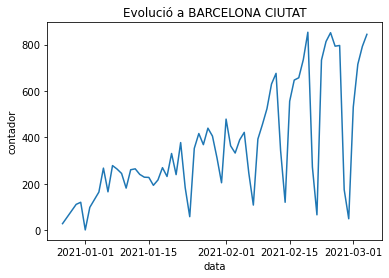

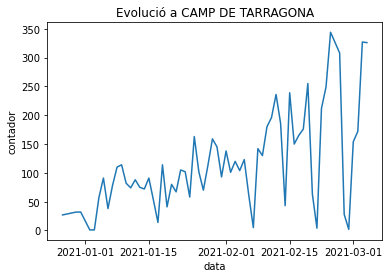

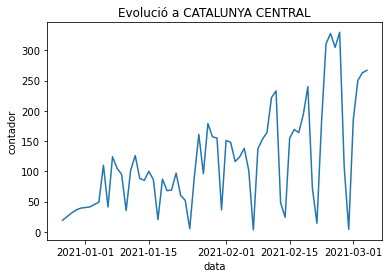

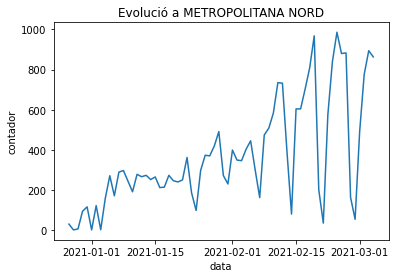

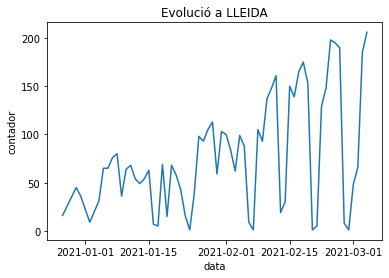

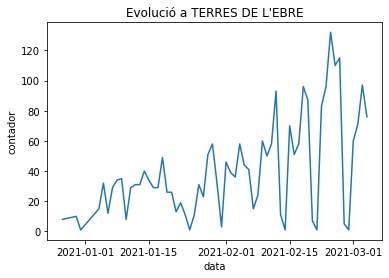

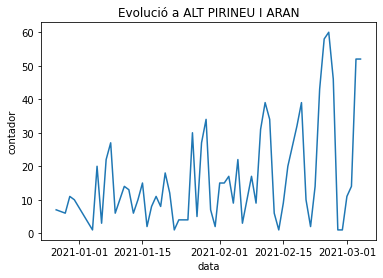

In [230]:
#Podemos ver la progresión de la vacunación por zona sanitaria.
for reg in listaRegions:
    var_ = vacun_groupby[vacun_groupby['regio'] == reg]
    sns.lineplot(x="data", y="contador", data=var_)
    plt.title("Evolució a " + reg)
    plt.show()

## 3. Modelling

### Model to predict next vaccinations - ARIMA

La región es: METROPOLITANA SUD


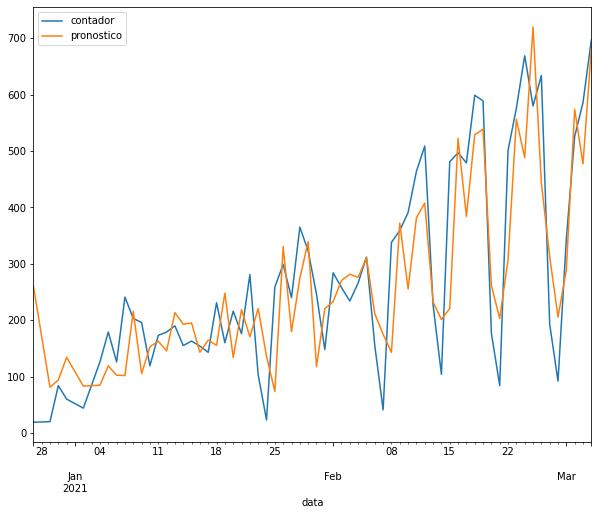

La región es: GIRONA


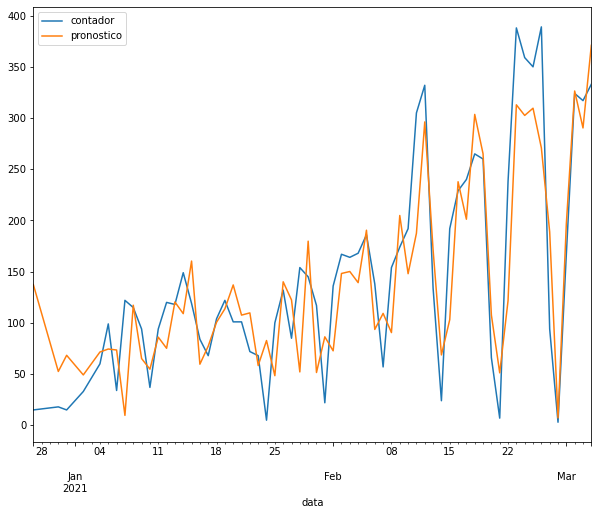

La región es: BARCELONA CIUTAT


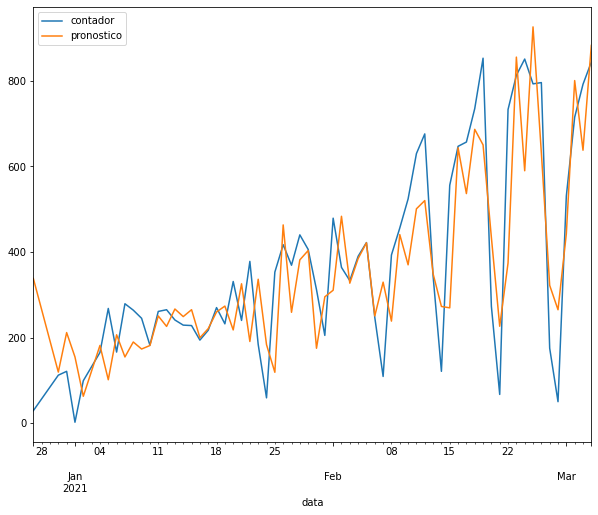

La región es: CAMP DE TARRAGONA


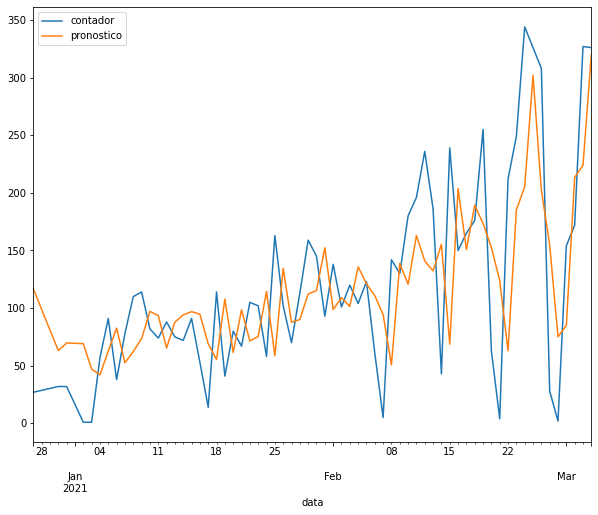

La región es: CATALUNYA CENTRAL


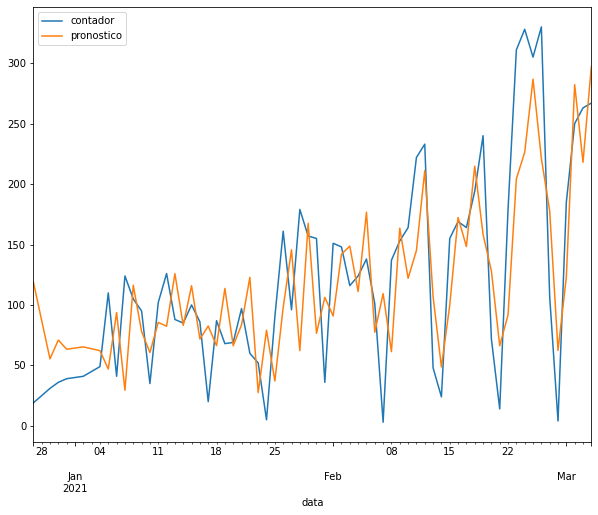

La región es: METROPOLITANA NORD


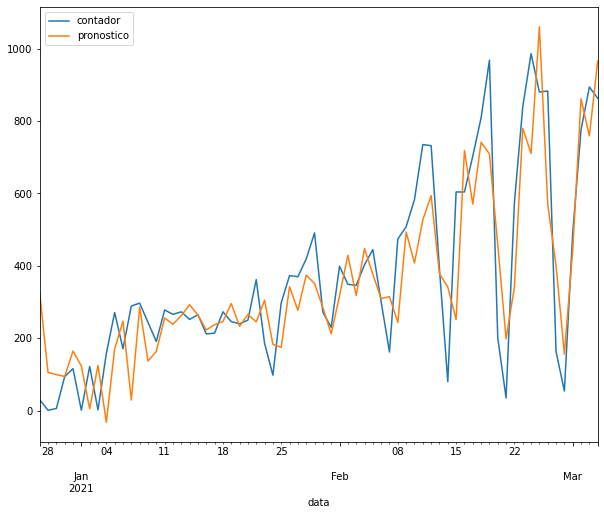

La región es: LLEIDA


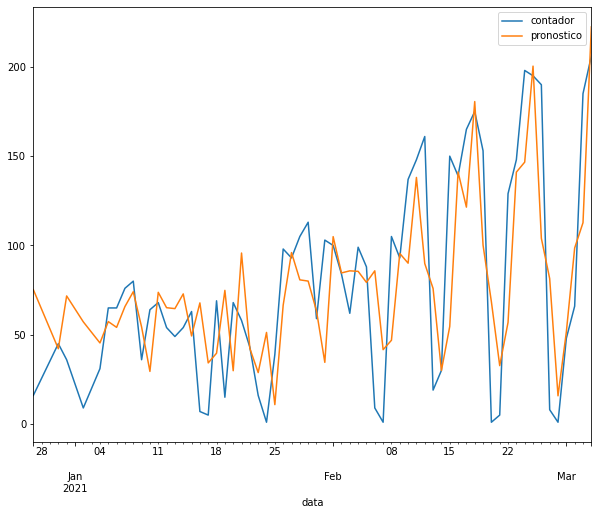

La región es: TERRES DE L'EBRE


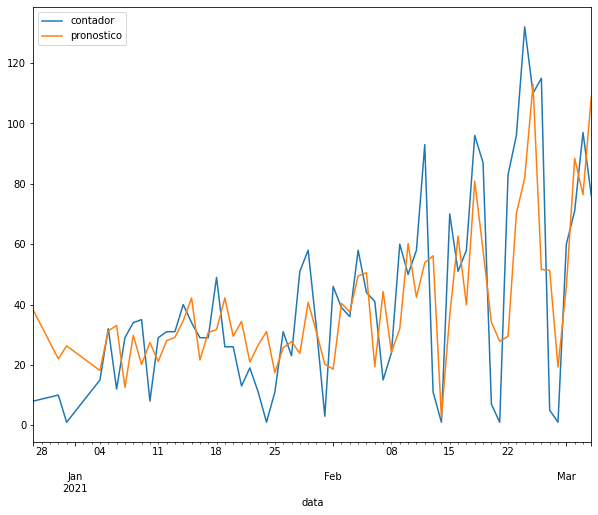

La región es: ALT PIRINEU I ARAN


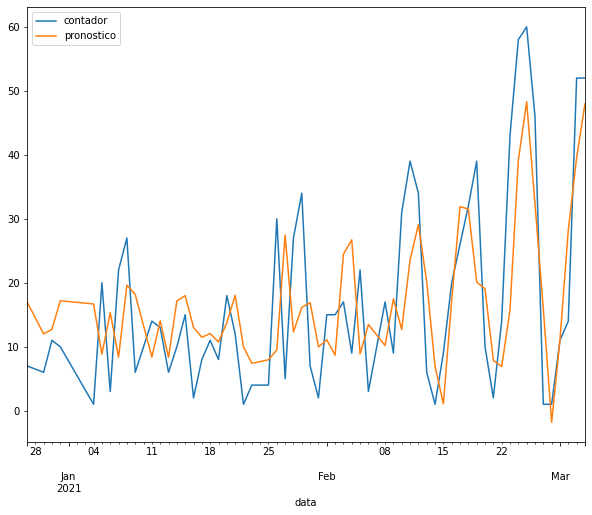

In [231]:
cont = -1

lista = ['regio0','regio1','regio2','regio3','regio4','regio5','regio6','regio8']

for reg in listaRegions:
    cont = cont + 1
    print('La región es: ' + reg)
    
    series = vacun_groupby[vacun_groupby['regio'] == reg]
    series = series[['data', 'contador']]
    series.index = pd.DatetimeIndex(series.data).to_period('D')
    series = series.drop('data', axis = 1)
    
    series_ = series
    modelo = sm.tsa.ARIMA(series_, order=(6,0, 0))  
    resultados = modelo.fit(solver = 'lbfgs') 
    #resultados = modelo.fit(solver = 'lbfgs')  
    #resultados = modelo.fit(solver = 'cg') 
    #resultados = modelo.fit(solver = 'nm')
    series_['pronostico'] = resultados.fittedvalues  
    series_[['contador', 'pronostico']].plot(figsize=(10, 8)) 
    
    start_index = vacun_groupby.data.max() 
    end_index = vacun_groupby.data.max() + datetime.timedelta(days=7)
    forecast = resultados.predict(start=start_index, end=end_index)


    if cont != 1:
        regionPredict = pd.DataFrame(forecast).rename({0:reg}, axis = 1)
        regionPredict['dataPredict'] = regionPredict.index.to_series().astype(str)
        regionPredict['dataPredict'] = pd.to_datetime(regionPredict['dataPredict'], format='%Y-%m-%d')
        regionPredict = regionPredict.reset_index()
        regionPredict = regionPredict.drop('index', axis = 1)
        regionPredict = regionPredict[regionPredict['dataPredict'] >= start_index]
    
    if cont == 1:
        regionPredict_ = pd.DataFrame(forecast).rename({0:reg}, axis = 1)
        regionPredict_['dataPredict'] = regionPredict_.index.to_series().astype(str)
        regionPredict_['dataPredict'] = pd.to_datetime(regionPredict_['dataPredict'], format='%Y-%m-%d')
        regionPredict_ = regionPredict_.reset_index()
        regionPredict_ = regionPredict_.drop('index', axis = 1)
        regionPredict_ = regionPredict_[regionPredict_['dataPredict'] >= start_index]
        regionPredict_ = pd.merge(left=regionPredict, right=regionPredict_, left_on='dataPredict', right_on='dataPredict', how = 'right')

    elif cont > 1:
        regionPredict_ = pd.merge(left=regionPredict_, right=regionPredict, left_on='dataPredict', right_on='dataPredict', how = 'left')
        
    plt.show()

In [232]:
#Predicciones por zonas sanitárias
regionPredict_

,METROPOLITANA SUD,dataPredict,GIRONA,BARCELONA CIUTAT,CAMP DE TARRAGONA,CATALUNYA CENTRAL,METROPOLITANA NORD,LLEIDA,TERRES DE L'EBRE,ALT PIRINEU I ARAN
0,199.857006,2021-03-04,179.414151,253.390205,101.566649,96.911576,965.925895,23.287035,66.275314,34.666710
1,355.866542,2021-03-05,276.624229,518.184726,108.078236,164.864946,545.819804,73.614436,71.113866,25.637898
2,439.882064,2021-03-06,291.184654,642.831225,181.178501,203.460204,180.786058,140.881481,54.457054,11.351661
3,539.291311,2021-03-07,296.475839,716.258060,234.303127,208.285655,237.498762,144.752508,31.846809,3.525285
4,607.557654,2021-03-08,246.292764,738.197927,212.120478,228.887831,524.914672,105.621804,28.819128,10.600168
5,482.179119,2021-03-09,118.200511,484.889789,157.243293,179.386293,731.739843,75.186378,35.439002,21.723506
6,287.517666,2021-03-10,86.544766,266.469898,125.220946,120.640440,812.062323,42.532724,47.008329,29.075061
7,273.094217,2021-03-11,177.166911,343.842218,105.720564,121.722512,725.314676,37.082663,57.177522,29.233143


La región es METROPOLITANA SUD


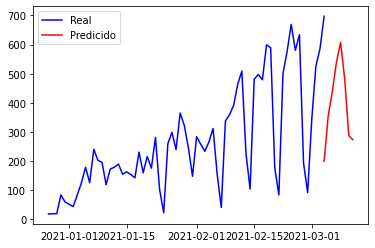

La región es GIRONA


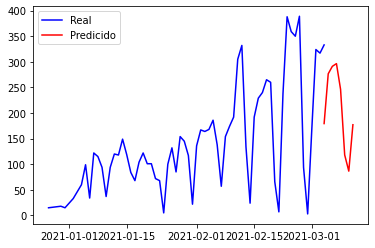

La región es BARCELONA CIUTAT


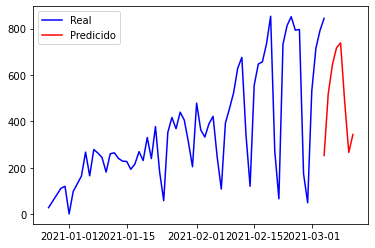

La región es CAMP DE TARRAGONA


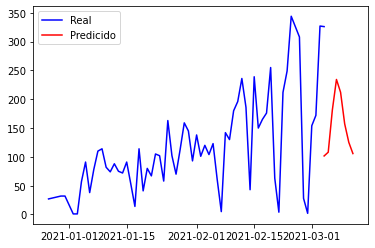

La región es CATALUNYA CENTRAL


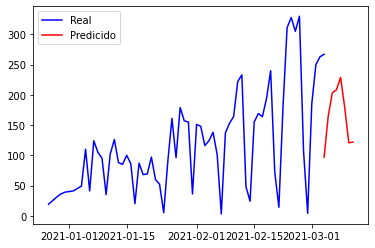

La región es METROPOLITANA NORD


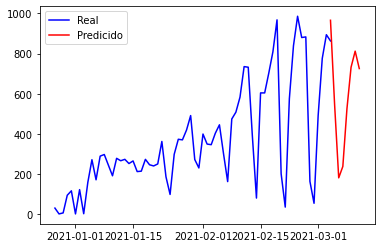

La región es LLEIDA


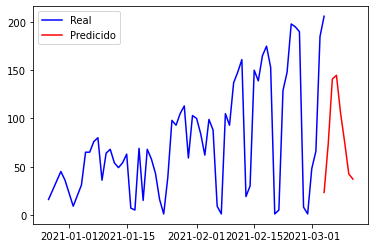

La región es TERRES DE L'EBRE


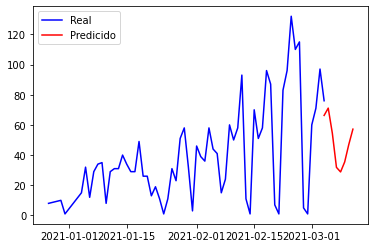

La región es ALT PIRINEU I ARAN


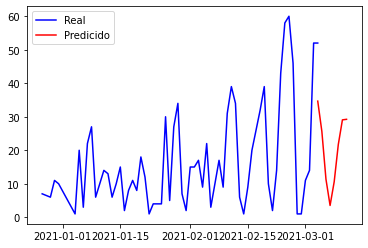

In [233]:
#Ploteamos las diferentes predicciones en color rojo por cada zona sanitaria.
for col in regionPredict_.columns:
    if col != "dataPredict":
        
        print('La región es ' + str(col))
    
        dataOriginal = vacun_groupby[vacun_groupby['regio'] == col]

        plt.plot('data' , 'contador', data=dataOriginal, c = 'blue')
        plt.plot('dataPredict', col, data=regionPredict_, c = 'red')
        plt.legend(['Real', "Predicido"])
        plt.show()

### Predictions obtained for the next 5 days by health region.

In [234]:
#We have data from 4th of March because we download csv about vaccine 5th of march. So we want calculate from 6th - 10th of March
FirstDayPrediction = regionPredict_.dataPredict.min() + datetime.timedelta(days=1)
LastDayPrediction = regionPredict_.dataPredict.min() + datetime.timedelta(days=7)
regionPredict_ = regionPredict_[(regionPredict_['dataPredict'] > FirstDayPrediction) & (regionPredict_['dataPredict'] < LastDayPrediction)]
regionPredict_

,METROPOLITANA SUD,dataPredict,GIRONA,BARCELONA CIUTAT,CAMP DE TARRAGONA,CATALUNYA CENTRAL,METROPOLITANA NORD,LLEIDA,TERRES DE L'EBRE,ALT PIRINEU I ARAN
2,439.882064,2021-03-06,291.184654,642.831225,181.178501,203.460204,180.786058,140.881481,54.457054,11.351661
3,539.291311,2021-03-07,296.475839,716.258060,234.303127,208.285655,237.498762,144.752508,31.846809,3.525285
4,607.557654,2021-03-08,246.292764,738.197927,212.120478,228.887831,524.914672,105.621804,28.819128,10.600168
5,482.179119,2021-03-09,118.200511,484.889789,157.243293,179.386293,731.739843,75.186378,35.439002,21.723506
6,287.517666,2021-03-10,86.544766,266.469898,125.220946,120.640440,812.062323,42.532724,47.008329,29.075061


In [235]:
sumasDosis = np.zeros(len(regionPredict_.columns) - 1)
cont = 0
for col in regionPredict_.columns:
    if col != 'dataPredict':
        sumasDosis[cont] = (round(regionPredict_[col].sum()))
        cont += 1
        
DosisNextDays = pd.DataFrame([sumasDosis], columns=['METROPOLITANA SUD','GIRONA','BARCELONA CIUTAT','TARRAGONA','CATALUNYA CENTRAL','METROPOLITANA NORD','LLEIDA',"TERRES DE L'EBRE", 'ALT PIRINEU I ARAN'])
DosisNextDays

,METROPOLITANA SUD,GIRONA,BARCELONA CIUTAT,TARRAGONA,CATALUNYA CENTRAL,METROPOLITANA NORD,LLEIDA,TERRES DE L'EBRE,ALT PIRINEU I ARAN
0,2356.0,1039.0,2849.0,910.0,941.0,2487.0,509.0,198.0,76.0
